# VRP RL with DQN and Graph Embedding

In [ ]:
import numpy as np
import torch
import random
import math
import time
import os

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Configuration class

In [ ]:
class Config:
    def __init__(self):
        self.truckCapacity = 50 #Capacity of truck
        self.numCust = 10 #Number of customer nodes
        self.numDepot = 1 #Number of depots
        self.randomSeed = 1  #Random Seed
        self.numEpisode = 10000 #Number of Episodes
        self.embeddingDimension = 5 #Dimension of embedding of node
        self.embeddingIteration = 1 #Number of iterations to generate embedding
        self.nnNodeDimension = 5 #Dimension of features of node
        self.numPaddingLayers = 1 #Number of padding layers
        self.numPrevStates = 10000 #Number of previous states in history
        self.numQLStep = 2 #N-Step Q-Learning
        self.gdBatchSize = 25 #Number of samples to perform gradient descent in network
        self.epsilonMin = 0.1 #Minimum value of Epsilon
        self.epsilonDR = 0.0006 #Decay rate of Epsilon
        self.checkpointFolder = "gdrive/My Drive/CSC591-ADBI/Capstone/Code/10Node2/" #CheckPoint folder
        self.depotReward = 10 #Reward for visiting depot
        self.minEventsForGD = 3000 #Minimum number of events required to perform gradient descent in the network
        self.checkPointThreshold = 200 #Checkpoint Threshold

In [ ]:
config = Config()
np.random.seed(config.randomSeed)
random.seed(config.randomSeed)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cpu')
torch.manual_seed(config.randomSeed)  

State Class which is used through out the code to maintain the state

In [ ]:
class State:
    def __init__(self, createNew = True, numCust=None, numDepots = None, capacity = None, visitedNodes = None, nodeLocations = None, demands = None, nodeDistances = None):
        #Creates a new State which is empty
        if createNew:
            self.visitedNodes = [] #Visited Nodes
            self.satisfiedDemand = 0 #Total demand satisfied
            self.nodeLocations, self.nodeDistances, self.demands = generateNodes(numCust, numDepots) #Node locations, Distances, Demands
            self.leftDemand = sum(self.demands) #Total Demand left
            self.truckCapacity = capacity #Truck Capacity
        else:
          #Creates a state based on the exist8ing information and updates the values of various parameters accordingly
            self.visitedNodes = visitedNodes
            self.satisfiedDemand = sum([demands[node] for node in visitedNodes])
            self.nodeLocations, self.nodeDistances, self.demands = nodeLocations, nodeDistances, demands
            self.truckCapacity = capacity
            self.leftDemand = 0
            for node in range(len(demands)):
                if node not in visitedNodes:
                    self.leftDemand += self.demands[node]
        
    #Generate a vector (Tensor) of the current state with the features to generate embedding
    def getTensor(self):
        numNodes = self.nodeLocations.shape[0]
        tensor = []
        for i in range(0, numNodes):
            tmp = []
            tmp.append(0 if self.demands[i] > 0 else 0) #Is the node a depot
            tmp.append(-1 if i not in self.visitedNodes else self.visitedNodes.index(i)) #Is the node visited
            tmp.append(self.nodeLocations[i, 0]) #x-coordinate of node
            tmp.append(self.nodeLocations[i, 1]) #y-coordinate of node
            tmp.append(self.leftDemand) #Total demand left at the moment
            tensor.append(tmp) 
        return torch.tensor(tensor, dtype=torch.float32, requires_grad=False, device=device)
    
    def isFinalState(self):
        return self.leftDemand == 0

Utilities Class for methods required through out

In [ ]:
class Utils:
    def __init__(self):
        pass
    #Generate the graph with nodes, paiwise distances and demands
    def generateNodes(self):
        global config
        nodeLocations = np.random.uniform(size=(config.numCust + config.numDepot ,2))
        nodeDistances = distance_matrix(nodeLocations, nodeLocations)
        demands = np.random.randint(1, 10, (config.numCust + config.numDepot))
        for i in range(config.numDepot):
            demands[i] = 0
        return nodeLocations, nodeDistances, demands
    #Calculates the total distance travelled till the moment. It uses pairwise distances calculated earlier
    def distanceTravelled(self, nodeDistances, visitedNodes):
        distTravelled = 0
        if len(visitedNodes) > 2:
            for i in range(len(visitedNodes) - 1):
                distTravelled += nodeDistances[visitedNodes[i], visitedNodes[i+1]].item()
        return distTravelled
    
    #Generate a random next node based on the current state, capacity left in the truck
    def nextRandomNode(self, state, leftCapacity, demands):
        global config
        #If no nodes are visited, select a random Node which is a depot
        if len(state.visitedNodes) == 0:
            return np.random.randint(0, (config.numDepot))
        #If there are few nodes visited, we select the next node as a random customer node which is not visited earlier
        visited = set(state.visitedNodes)
        nodes = list(range(config.numDepot, (config.numDepot + config.numCust)))
        np.random.shuffle(nodes)
        for node in nodes:
          #We select the node whose demand can be satisfied with left over truck capacity
            if (node not in visited) and (leftCapacity >= demands[node]):
              return node
        #If no such node is found, we visit a depot
        return np.random.randint(0, config.numDepot)
    
    #Calculate the reward for list of visited nodes
    def calculateReward(self, visitedNodes, newVisitedNodes, nodeDistances):
        global config
        newTotalDistance = self.distanceTravelled(nodeDistances, newVisitedNodes)
        oldTotalDistance = self.distanceTravelled(nodeDistances, visitedNodes)
        
        reward = -1.0 * (newTotalDistance - oldTotalDistance)
        #Add the reward for visiting depot along the path
        for node in newVisitedNodes:
          if node < config.numDepot:
            reward -= config.depotReward   
        return reward
    
    #Plot the graph of nodes visited with path
    def plotGraph(self, nodeLocations, visitedNodes):
        plt.scatter(nodeLocations[:,0], nodeLocations[:,1])
        n = len(nodeLocations)
        for idx in range(len(visitedNodes)-1):
          plt.plot([nodeLocations[visitedNodes[idx], 0], nodeLocations[visitedNodes[idx+1], 0]], [nodeLocations[visitedNodes[idx], 1], nodeLocations[visitedNodes[idx+1], 1]], 'k', lw=2, alpha=0.8)
        for node in visitedNodes:
          #Mark the depots to make sure we identify them on the graph
          if node < config.numDepot:
            plt.plot(nodeLocations[node, 0], nodeLocations[node, 1], 'X', markersize=15)
    
    #Get the updated Epsilon value for the episode
    def getEpsilonValueForEpisode(self, episode):
        global config
        episodeValue = (1-config.epsilonDR)**episode
        return max(config.epsilonMin, episodeValue)
    
    #Get all the required sample data to begin an episode. 
    def getSamplesForEpisode(self):
        nodeLocations, nodeDistances, demands = self.generateNodes()
        global config
        nodeDistances = torch.tensor(nodeDistances, dtype=torch.float32, requires_grad=False, device=device) #Generate a graph
        visitedNodes = [random.randint(0, config.numDepot-1)] #Select a random depot node to start with
        return nodeLocations, nodeDistances, demands, visitedNodes

In [ ]:
utils = Utils()

Event Class which is stored in the history. History Class is a collection of Events

In [ ]:
class Event():
    def __init__(self, state, nextState, reward, action):
        self.state = state #Current State
        self.stateTensor = state.getTensor() #Current State Tensor
        self.nextState = nextState #Next State
        self.nextStateTensor = nextState.getTensor() #Next State Tensor
        self.reward = reward #Reward obtained
        self.action = action #Action performed
        
class History():
    def __init__(self):
        global config
        self.pastEvents = []
        self.numEvents = 0
    
    #Add an event to History
    def addPastEvent(self, event):
        global config
        #Override a past event if capacity if full
        if self.numEvents > config.numPrevStates:
            self.pastEvents[self.numEvents % config.numPrevStates] = event
        else:
            self.pastEvents.append(event)
        self.numEvents += 1 #Update the number of events in history
    
    #Get the number of events in History
    def getNumPastEvents(self):
      #If more than capacity, return capacity
        if self.numEvents > len(self.pastEvents):
            return len(self.pastEvents)
        else:
            return self.numEvents
    
    #Sample a batch of events from the history
    def getSamplePast(self):
        global config
        return random.sample(self.pastEvents, config.gdBatchSize)
    
    #Add event and past states based on the N-Step Q Learning
    def addToHistory(self, visitedNodes, rewards, states, newState, actions):
        global config
        #Add previous N-States information
        if len(visitedNodes) >= config.numQLStep:
            lastState = states[-config.numQLStep]
            rewardsSum = sum(rewards[-config.numQLStep:])
            actionPerformed = actions[-config.numQLStep]
            newEvent = Event(lastState, newState, rewardsSum, actionPerformed)
            self.addPastEvent(newEvent)
        
        #If we reached a final state, add all the states results in the final state
        if newState.isFinalState():
            for step in range(1, config.numQLStep):
                lastState = states[-step]
                rewardsSum = sum(rewards[-step:])
                actionPerformed = actions[-step]
                event = Event(lastState, newState, rewardsSum, actionPerformed)
                self.addPastEvent(event)

Neural Network for Q-Learning

In [ ]:
class DQN(nn.Module):    
    def __init__(self):
        super(DQN, self).__init__()
        
        global config
        #Creating layers for the learnable theta parameters in our action-value funtion
        self.theta1 = nn.Linear(config.nnNodeDimension, config.embeddingDimension, True)
        self.theta2 = nn.Linear(config.embeddingDimension, config.embeddingDimension, True)
        self.theta3 = nn.Linear(config.embeddingDimension, config.embeddingDimension, True)
        self.theta4 = nn.Linear(1, config.embeddingDimension, True)
        self.theta5 = nn.Linear(2*config.embeddingDimension, 1, True)
        self.theta6 = nn.Linear(config.embeddingDimension, config.embeddingDimension, True)
        self.theta7 = nn.Linear(config.embeddingDimension, config.embeddingDimension, True)
        
        #Add padding layers if needed
        self.padding = []
        for i in range(config.numPaddingLayers):
            self.padding.append(nn.Linear(config.embeddingDimension, config.embeddingDimension, True))
    
    #Forward pass through the network
    def forward(self, features, nodeLocations):
        global config
        #Calculate the first term of our action-value function which is based on the features of the node
        term1 = self.theta1(features)
        for layer in self.padding:
            term1 = layer(F.relu(term1))
        #The Third term of our equation which is an aggregate of distances of all the neighboring nodes
        term3 = self.theta3(torch.sum(F.relu(self.theta4(nodeLocations.unsqueeze(3))), dim=1))
        
        #The second term which is the aggregate of embeddings of all neighboring nodes iterated for T times
        connections = torch.where(nodeLocations > 0, torch.ones_like(nodeLocations), torch.zeros_like(nodeLocations)).to(device)
        mu = torch.zeros(features.shape[0], (config.numCust + config.numDepot), config.embeddingDimension, device=device)
        for t in range(config.embeddingIteration):
            term2 = self.theta2(connections.matmul(mu))    
            mu = F.relu(term1 + term2 + term3)

        #Aggregate of final embeddings of neighbors
        term6 = self.theta6(torch.sum(mu, dim=1, keepdim=True).repeat(1, (config.numCust + config.numDepot), 1))
        term7 = self.theta7(mu)
        #Final action value function result
        concat = F.relu(torch.cat([term6, term7], dim=2))
        return self.theta5(concat).squeeze(dim=2)

Helper Class to perform operations on Network

In [ ]:
class Helper():
    def __init__(self):
        global config
        self.network = DQN().to(device) #instance of network
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.005) #optimizer
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma = 0.99998) #Scheduler
        self.lossFunc = nn.MSELoss() #Loss Function
    
    #Load an existing model and update parameters
    def loadModel(self, fileName):
        global config
        if fileName is not None:
            checkpoint = torch.load(fileName)
            self.network.load_state_dict(checkpoint['network'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.scheduler.load_state_dict(checkpoint['scheduler'])
    
    #Save the current model parameters
    def saveCheckPoint(self, episode, loss, averageLength):
        global config
        fname = config.checkpointFolder + F"length_{averageLength}.tar"
        torch.save({'episode': episode, 'network': self.network.state_dict(), 'optimizer': self.optimizer.state_dict(), 'scheduler': self.scheduler.state_dict(), 'loss': loss, 'averageLength': averageLength
        }, fname)
    
    #Predict the rewards of all possible actions based on current state
    def predict(self, state):
        with torch.no_grad():
            rewards = self.network(state.getTensor().unsqueeze(0), state.nodeDistances.unsqueeze(0))
        return rewards[0]

    #Get the next best action        
    def getNextAction(self, state, leftCapacity):  
        rewards = self.predict(state) #Calculate Rewards for all actions
        
        rewardsindices = rewards.argsort(descending=True) #Sort the rewards

        #Pick the node which results in maximum reward and making sure that it is not visited previously and the demand can be satisfied by current truck capacity
        for node in rewardsindices.tolist():
          if (node >= config.numDepot) and (node not in state.visitedNodes) and (state.demands[node] <= leftCapacity):
            return node, rewards[node].item()
        #If no such node is left, return a random depot node as next node
        randomDepot = np.random.randint(0, config.numDepot)
        return randomDepot, rewards[randomDepot].item()
    
    #Update the paramters of the network for a given sample of past events
    def update(self, events):
        global confi
        stateTensors = []
        distanceTensors = []
        actions = []
        targetRewards = []
        #Generate a list of tensors for performing update
        for event in events:
            stateTensors.append(event.stateTensor)
            distanceTensors.append(event.state.nodeDistances)
            actions.append(event.action)
            
        distanceTensors = torch.stack(distanceTensors).to(device)
        stateTensors = torch.stack(stateTensors).to(device)

        #Calculate the target reward as the sum of rewards at each step for every event and the reward for the next state for a non terminal State
        for i, event in enumerate(events):
            targetReward = event.reward
            leftCapacity = np.max(config.truckCapacity - (sum([demands[node] for node in event.state.visitedNodes])), 0)
            if not event.nextState.isFinalState():
                node, reward = self.getNextAction(event.nextState, leftCapacity)
                if node >= config.numDepot:
                  leftCapacity -= event.state.demands[node]
                else:
                  leftCapacity = config.truckCapacity
                targetReward += 0.9 * reward
            targetRewards.append(targetReward)

        #Clear the existing gradients in the optimiser       
        self.optimizer.zero_grad()
        #Calculate the rewards
        rewards = self.network(stateTensors, distanceTensors)[range(len(actions)), actions]
        #Calculate loss with respect to target rewards
        loss = self.lossFunc(rewards, torch.tensor(targetRewards, device=device))
        lossValue = loss.item()

        #Propagate the loss and update parameters of network
        loss.backward()
        self.optimizer.step()        
        self.scheduler.step()
        
        return lossValue

Training the model

In [ ]:
helper = Helper()
history = History()
pathLengths = []
medianPathLength = float('inf')

#Iterate over number of episodes
for episode in range(config.numEpisode):
    
    currentEpsilon = utils.getEpsilonValueForEpisode(episode) #Get current epsilon value
    nodeLocations, nodeDistances, demands, visitedNodes = utils.getSamplesForEpisode() #Generate graph and necessary information to begin
    oldState = State(createNew=False, visitedNodes=visitedNodes, nodeDistances=nodeDistances, nodeLocations=nodeLocations, demands = demands, capacity = config.truckCapacity) #Generate State
    oldStateTensor = oldState.getTensor() #Generate State Tensor
    states = [oldState] #List of states for current episode
    stateTensors = [oldStateTensor] #List of state tensors
    rewards = [] #List of rewards
    actions = [] #list of actions performed which is essentially the order of nodes visited

    leftCapacity = config.truckCapacity

    #While we have demands to be satisfied
    while not oldState.isFinalState():
        if currentEpsilon < random.random():
          #Get node based on Q-Function
            newNode, reward = helper.getNextAction(oldState, leftCapacity)
        else:
          #Get Random node
            newNode = utils.nextRandomNode(oldState, leftCapacity, demands)
        #If the node is depot, update the leftover truck capacity
        if(newNode < config.numDepot):
          leftCapacity = config.truckCapacity
        else:
          leftCapacity -= demands[newNode]

        #Update the new list of visited nodes
        newVisitedNodes = list(visitedNodes)
        newVisitedNodes.append(newNode) 

        #Calculate Reward  
        reward = utils.calculateReward(visitedNodes, newVisitedNodes, nodeDistances)
        
        #Create new State and corresponding tensor
        newState = State(createNew=False, visitedNodes=newVisitedNodes,nodeDistances=nodeDistances, nodeLocations=nodeLocations, demands = demands, capacity = leftCapacity)
        newStateTensor = newState.getTensor()

        states.append(newState)
        stateTensors.append(newStateTensor)
        rewards.append(reward)
        actions.append(newNode)
        
        #Add event to history
        history.addToHistory(visitedNodes, rewards, states, newState, actions)
        
        #update the state to new state
        oldState = newState
        oldStateTensor = newStateTensor
        visitedNodes = newVisitedNodes
        
        loss = None
        #If there are enough events, sample and update the model parameters
        if history.getNumPastEvents() > config.minEventsForGD:
            events = history.getSamplePast()
            loss = helper.update(events)
        #Save the model at checkpoint
        if loss and (episode%config.checkPointThreshold == 0):
            medianPathLength = np.median(pathLengths[-config.checkPointThreshold:])
            helper.saveCheckPoint(episode, loss, medianPathLength)

    #Calculate total path length            
    length = utils.distanceTravelled(nodeDistances, visitedNodes)
    pathLengths.append(length)

    if episode % 100 == 0:
        print('Ep %d. median length = %.3f' % (episode, np.median(pathLengths[-50:])))

Ep 0. median length = 5.910
Ep 100. median length = 5.237
Ep 200. median length = 5.289
Ep 300. median length = 5.403
Ep 400. median length = 5.166
Ep 500. median length = 5.394
Ep 600. median length = 5.107
Ep 700. median length = 5.563
Ep 800. median length = 5.026
Ep 900. median length = 5.009
Ep 1000. median length = 4.985
Ep 1100. median length = 5.036
Ep 1200. median length = 4.725
Ep 1300. median length = 5.242
Ep 1400. median length = 4.926
Ep 1500. median length = 5.032
Ep 1600. median length = 4.908
Ep 1700. median length = 4.843
Ep 1800. median length = 5.048
Ep 1900. median length = 4.800
Ep 2000. median length = 5.064
Ep 2100. median length = 4.558
Ep 2200. median length = 4.545
Ep 2300. median length = 4.666
Ep 2400. median length = 4.997
Ep 2500. median length = 4.449
Ep 2600. median length = 4.839
Ep 2700. median length = 4.797
Ep 2800. median length = 4.557
Ep 2900. median length = 4.845
Ep 3000. median length = 4.296
Ep 3100. median length = 4.450
Ep 3200. median leng

Plot the moving average of path lengths

Text(0.5, 0, 'episode')

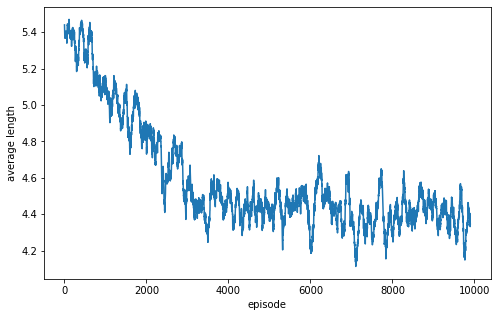

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(np.convolve(np.array(pathLengths), np.ones((100,))/100, mode='valid'))
plt.ylabel('average length')
plt.xlabel('episode')

Generate sample graphs to visualise the results

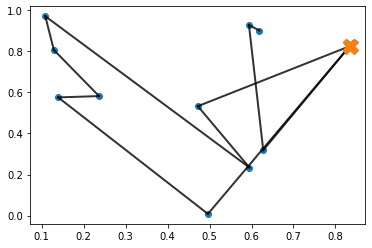

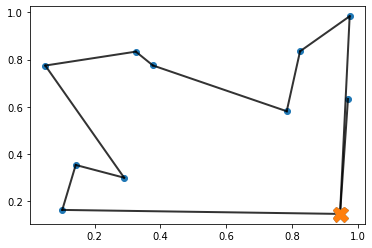

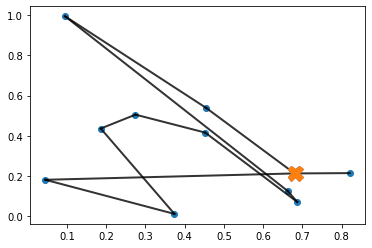

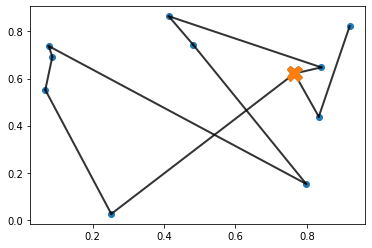

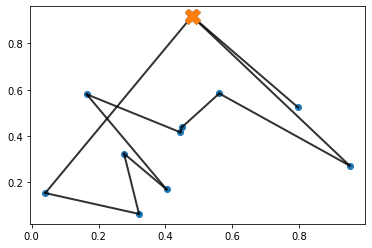

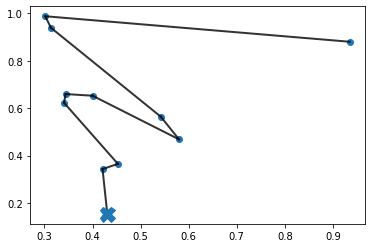

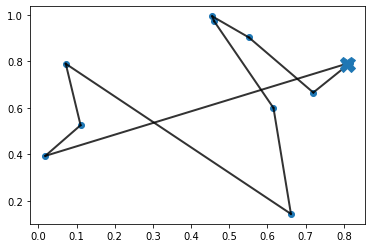

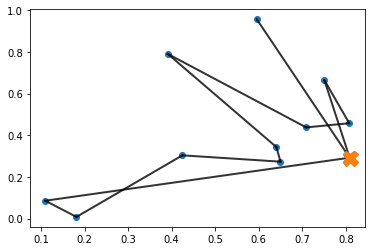

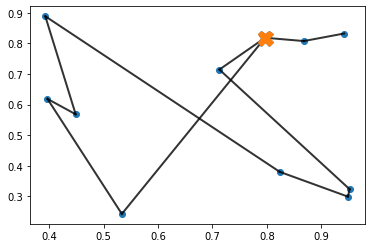

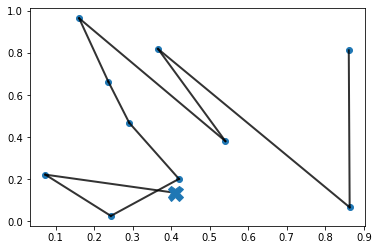

In [ ]:
bestModelFileName = F"gdrive/My Drive/CSC591-ADBI/Capstone/Code/10Node2/length_4.32422966696322.tar" #Select model with best performance from the checkpoints

testHelper = Helper()
testHelper.loadModel(bestModelFileName)
  
sampleResults = list()

for sample in range(10):
  #Generate Initial data to begin with
  nodeLocations, nodeDistances, demands, visitedNodes = utils.getSamplesForEpisode()
  
  oldState = State(createNew=False, visitedNodes=visitedNodes, nodeDistances=nodeDistances, nodeLocations=nodeLocations, demands = demands, capacity = config.truckCapacity)
  oldStateTensor = oldState.getTensor()
  leftCapacity = config.truckCapacity
  depotVisit = True
  while not oldState.isFinalState():
    #Use the model to get next best action        
    newNode, reward = testHelper.getNextAction(oldState, leftCapacity) 
    visitedNodes.append(newNode)

    #Update the left truck capacity
    if(newNode < config.numDepot):
      leftCapacity = config.truckCapacity
    else:
      leftCapacity -= demands[newNode]
    oldState = State(createNew=False, visitedNodes=visitedNodes,nodeDistances=nodeDistances, nodeLocations=nodeLocations, demands = demands, capacity = leftCapacity)
    oldStateTensor = oldState.getTensor()
  sampleResults.append((nodeLocations, visitedNodes))
    
#Plot the results
for solution in sampleResults:
    plt.figure()
    utils.plotGraph(solution[0], solution[1])
    